Import all the dependencies

In [1]:
import os, random , math, shutil, glob, uuid
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from stop_words import get_stop_words

from sklearn.model_selection import train_test_split
import numpy as np
np.set_printoptions(threshold=np.nan)


/home/ubuntu/Desktop/tensorflow-gpu/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/Desktop/tensorflow-gpu/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Initialize all the Global Variables for Train, Validation, and Test Data. 

In [2]:
''' Below are all the "global" constants used in the model (not hyperparameters or graph parameters)'''



home_dir = '/home/ubuntu/Desktop/nlp_deep/amazon_data_sample/'
one_hot_train_dir = home_dir + 'train/'
one_hot_valid_dir = home_dir + 'valid/'
one_hot_test_dir = home_dir + 'test/'
train_file = home_dir + 'train_sample.csv'
test_file = home_dir + 'test_sample.csv'



'''
home_dir = '/home/nitin/Desktop/sdb1/all_files/amazon_reviews_data/'
one_hot_train_dir = '/home/nitin/Desktop/sdb1/all_files/amazon_reviews_data/train/'
one_hot_valid_dir = '/home/nitin/Desktop/sdb1/all_files/amazon_reviews_data/valid/'
one_hot_test_dir = '/home/nitin/Desktop/sdb1/all_files/amazon_reviews_data/test/'
train_file = home_dir + 'amazon_review_full_csv/train_sample.csv'
test_file = home_dir + 'amazon_review_full_csv/test_sample.csv'
'''


# Stores all the checkpoint models
checkpoint_dir = '/home/ubuntu/Desktop/nlp_deep/checkpoints/'
#checkpoint_dir = '/home/nitin/Desktop/sdb1/all_files/amazon_reviews_data/checkpoints/'



# Index denotes the column placement in the character embedding matrix
# This is used to create the one-hot character vector of sentence inputs

'''
one_hot_column_label = {'a':68,'b':67,'c':66,'d':65,'e':64,'f':63,'g':62,'h':61,'i':60,'j':59,'k':58,'l':57,'m':56,'n':55,'o':54,
                        'p':53,'q':52,'r':51,'s':50,'t':49,'u':48,'v':47,'w':46,'x':45,'y':44,'z':43,'0':42,'1':41,'2':40,'3':39,'4':38,'5':37,'6':36,'7':35,
                        '8':34,'9':33,'-':32,',':31,';':30,'.':29,'!':28,'?':27,':':26,'"':25,'\'':24,'/':23,'\\':22,'|':21,'_':20,
                        '@':19,'#':18,'$':17,'%':16,'^':15,'&':14,'*':13,'~':12,'`':11,'+':10,'-':9,'=':8,'<':7,'>':6,'(':5,')':4,'[':3,
                        ']':2,'{':1,'}':0}
'''

one_hot_column_label = {'a':42,'b':41,'c':40,'d':39,'e':38,'f':37,'g':36,'h':35,'i':34,'j':33,'k':32,'l':31,'m':30,'n':29,'o':28,
                        'p':27,'q':26,'r':25,'s':24,'t':23,'u':22,'v':21,'w':20,'x':19,'y':18,'z':17,'0':16,'1':15,'2':14,'3':13,'4':12,'5':11,'6':10,'7':9,
                        '8':8,'9':7,'-':6,'#':5,'.':4,'!':3,'?':2,':':1,';':0}




'''
one_hot_column_label = {'a':0,'b':1,'c':2,'d':3,'e':4,'f':5,'g':6,'h':7,'i':8,'j':9,'k':10,'l':11,'m':12,'n':13,'o':14,
                        'p':15,'q':16,'r':17,'s':18,'t':19,'u':20,'v':21,'w':22,'x':23,'y':24,'z':25,'A':26,'B':27,'C':28,'D':29,'E':30,'F':31,
                        'G':32,'H':33,'I':34,'J':35,'K':36,'L':37,'M':38,'N':39,'O':40,'P':41,'Q':42,'R':43,'S':44,'T':45,
                        'U':46,'V':47,'W':48,'X':49,'Y':50,'Z':51,'0':52,'1':53,'2':54,'3':55,'4':56,'5':57,'6':58,'7':59,
                        '8':60,'9':61,'-':62,',':63,';':64,'.':65,'!':66,'?':67,':':68,'"':69,'\'':70,'/':71,'\\':72,'|':73,'_':74,
                        '@':75,'#':76,'$':77,'%':78,'^':79,'&':80,'*':81,'~':82,'`':83,'+':84,'-':85,'=':86,'<':87,'>':88,'(':89,')':90,'[':91,
                        ']':92,'{':93,'}':94}

'''

'''
# For 1-1 mapping of character to letter encoding
one_hot_column_label = {'a':1,'b':2,'c':3,'d':4,'e':5,'f':6,'g':7,'h':8,'i':9,'j':10,'k':11,'l':12,'m':13,'n':14,'o':15,
                        'p':16,'q':17,'r':18,'s':19,'t':20,'u':21,'v':22,'w':23,'x':24,'y':25,'z':26,'0':27,'1':28,'2':29,'3':30,'4':31,'5':32,'6':33,'7':34,
                        '8':35,'9':36,'?':37,'!':38,' ':39,'$':40,'.':41}
'''
'''
one_hot_column_label = {'a':0,'b':1,'c':2,'d':3,'e':4,'f':5,'g':6,'h':7,'i':8,'j':9,'k':10,'l':11,'m':12,'n':13,'o':14,
                        'p':15,'q':16,'r':17,'s':18,'t':19,'u':20,'v':21,'w':22,'x':23,'y':24,'z':25,'0':26,'1':27,'2':28,'3':29,'4':30,'5':31,'6':32,'7':33,
                        '8':34,'9':35,'?':36,'!':37,'$':38,'.':39,' ':40}

'''

num_chars_dict = 43

# Number of labels to classify
num_labels = 5

# Tensorboard directories
train_tensorboard_dir = home_dir + 'train/tensorboard/'
valid_tensorboard_dir = home_dir + 'valid/tensorboard/'

log_dir = '/home/ubuntu/Desktop/nlp_deep/Char_CNN_log/'
#log_dir = '/home/nitin/Desktop/sdb1/all_files/amazon_reviews_data/log/'


Perform a 80-20 train-validation split. Get the length of the longest sentence, which will be used to build the graph.

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The longest sentence is of length:1003
The shortest sentence is of length:9
The average length is:428.683941052217
The 75th percentile is:584.0
The 90th percentile is:778.0
Verify Stratified Sampling
584
The cutoff length and counts
584
623999
26000


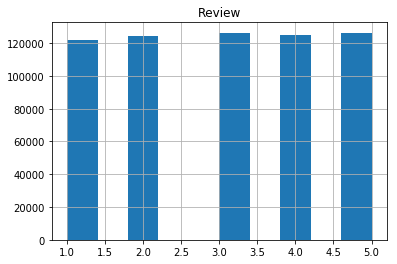

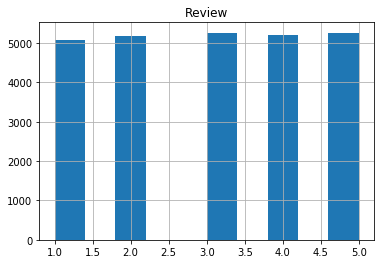

In [3]:

def strip_characters(sent):
    
    # Strip unnecessary characters from the review
    
    #sent = sent.replace('-','')
    sent = sent.replace(',','')
    #sent = sent.replace(';','')
    #sent = sent.replace('.','')
    #sent = sent.replace(':','')
    sent = sent.replace('"','')
    
    sent = sent.replace('/','')
    sent = sent.replace('\\','')
    sent = sent.replace('|','')
    sent = sent.replace('_','')
    sent = sent.replace('@','')
    #sent = sent.replace('#','')
    sent = sent.replace('$','')
    sent = sent.replace('^','')                        
    sent = sent.replace('&','')                        
    sent = sent.replace('*','')                        
    sent = sent.replace('~','')                            
    sent = sent.replace('`','')    
    sent = sent.replace('+','')                        
    sent = sent.replace('-','')    
    sent = sent.replace('=','')
    sent = sent.replace('<','')
    sent = sent.replace('>','')                        
    sent = sent.replace('(','')                        
    sent = sent.replace(')','')                        
    sent = sent.replace('[','')                        
    sent = sent.replace(']','')                        
    sent = sent.replace('{','')                        
    sent = sent.replace('}','')        
    
    
    # remove the stop words
    stop_words = list(get_stop_words('en'))
    nltk_words = list(stopwords.words('english'))
    stop_words.extend(nltk_words)
    
    #print (sent)
    #sent_words = sent.split(' ')
    #sent_stopped_words = [w for w in sent_words if not w in stop_words]
    #stopped_sent = ' '.join(sent_stopped_words)
    #print (stopped_sent)
    
                        
    return sent
                        
def main():                        
    nltk.download('stopwords')                        
    # Combine and label before train / valid split
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)

    # Are the datasets balanced - yes
    #print ('Checking Dataset Balance')
    #train_data.hist(column='Review')
    #test_data.hist(column='Review')


    # We get the max_len for padding and for the convolution filter definition in the model
    max_len = 0
    total_len = 0
    min_len = 999
    ls_len = []


    stripped_file_train =  home_dir + 'file_strip_train.csv'   
    stripped_file_test = home_dir + 'file_strip_test.csv'

    with open(stripped_file_train,'w') as strip:   
    
        strip.write('Review' + ',' + 'Description' + '\n')

        for index,row in train_data.iterrows():
    
            sent_row = strip_characters(row[2])
            strip.write(str(row[0]) + ','  + sent_row + '\n')    
        
        
    with open(stripped_file_test,'w') as strip:
     
        strip.write('Review' + ',' + 'Description' + '\n')
    
        for index,row in test_data.iterrows():
        
            sent_row = strip_characters(row[2])
            strip.write(str(row[0]) + ','  + sent_row + '\n')    

        

    strip_train_data = pd.read_csv(stripped_file_train)
    X_test = pd.read_csv(stripped_file_test)

        
    label_data = strip_train_data.loc[:,'Review']
    all_data = strip_train_data
    all_data = all_data.append(X_test,ignore_index=True)



    for index, row in all_data.iterrows():
        total_len += len(row[1])
        ls_len.append(len(row[1]))
        if (max_len < len(row[1])):
            max_len = len(row[1])
        if (min_len > len(row[1])):
            min_len = len(row[1])
            
    np_len = np.asarray(ls_len)

    print ('The longest sentence is of length:' + str(max_len))
    print ('The shortest sentence is of length:' + str(min_len))
    print ('The average length is:' + str(total_len/strip_train_data.shape[0]))
    print ('The 75th percentile is:' + str(np.percentile(np_len,75)))
    print ('The 90th percentile is:' + str(np.percentile(np_len,90)))



    # Train and test split (stratified sampling, 70-30 split)
    X_train,X_valid,y_train,y_valid = train_test_split(strip_train_data,label_data,test_size=0.04,train_size=0.96,random_state=13814,shuffle=True,stratify=label_data)
 
    # Verify that stratified sampling worked (histogram distributions must be same)
    print ('Verify Stratified Sampling')
    X_train.hist(column="Review") # First histogram is training
    X_valid.hist(column="Review") # Second histogram is validation


    'Some more "global" variables'
    cutoff_len = int(np.percentile(np_len,75)) # a graph parameter
    print(cutoff_len)
    train_count = X_train.shape[0]
    valid_count = X_valid.shape[0]
    
    return cutoff_len, train_count, valid_count, X_train, X_valid
    
    
cutoff_len, train_count, valid_count, X_train, X_valid = main()
print ('The cutoff length and counts')
print (str(cutoff_len))
print (str(train_count))       
print (str(valid_count))       


Now convert each sentence to one-hot character matrix to drive the non-static character embedding matrix creation, and store this character matrix representation in disk cache.

Also store in disk cache, the label and a one-hot representation of the label, for the cross-entropy loss.

In [4]:
# Creates the one-hot character vector representation of sentences which will be used as the layer before a
# character-embedding matrix
def save_numpy_one_hot(X_dataset,unique_char_size,save_dir,one_hot_column_label):
    
    for index,row in X_dataset.iterrows():
        
        #sent = row[2]
        sent = row[1]
        #print (sent)
        np_one_hot = np.zeros(shape=(len(sent),unique_char_size),dtype=np.int32)
        #np_one_hot = np.zeros(shape=len(sent),dtype=np.int32)
        
        for i in range(0,len(sent)):
            if (sent[i].lower() in one_hot_column_label):
                np_one_hot[i][one_hot_column_label[sent[i].lower()]] = 1 # else, it remains 0 encoded.
                #np_one_hot[i] = one_hot_column_label[sent[i].lower()] # For character embedding lookup
            #else:
            #    np_one_hot[i][41] = 1 # unknown character
        #print(np_one_hot)
            
        # Save the one-hot encoding for each sentence 
        np.save(save_dir + 'inputs/' + 'one_hot_sentence_' + str(index) + '.npy',np_one_hot)
        
        #Save the label
        lbl = int(row[0]) - 1 # Must start with 0-indexing
        np.save(save_dir + 'labels/' +  'sentence_label_' + str(index) + '.npy',np.asarray(lbl))
        
        # Save a one-hot version of the label (for xentropy loss function)
        np_one_hot_label = np.zeros(shape=(5),dtype=np.int32)
        np_one_hot_label[lbl] = 1
        
        np.save(save_dir + 'one_hot_labels/' + 'one_hot_sentence_label_' + str(index) + '.npy',np_one_hot_label)
        
        
def save_numpy_one_hot_test(X_dataset,unique_char_size,save_dir,one_hot_column_label):
    
    for index,row in X_dataset.iterrows():
        
        sent = row[1]
        np_one_hot = np.zeros(shape=(len(sent),unique_char_size),dtype=np.int32)
        #np_one_hot = np.zeros(shape=len(sent),dtype=np.int32)
        
        for i in range(0,len(sent)):
            if (sent[i].lower() in one_hot_column_label):
                np_one_hot[i][one_hot_column_label[sent[i].lower()]] = 1
                #np_one_hot[i] = one_hot_column_label[sent[i].lower()]
            #else:
            #    np_one_hot[i][41] = 1
            
        # Save the one-hot encoding for each sentence 
        np.save(save_dir + 'inputs/' + 'one_hot_sentence_' + str(index) + '.npy',np_one_hot)
        
        
def inp_create_one_hot_char_mat(unique_char_size,train_dir,valid_dir,test_dir):
    
    save_numpy_one_hot(X_train,unique_char_size,train_dir,one_hot_column_label)
    save_numpy_one_hot(X_valid,unique_char_size,valid_dir,one_hot_column_label)
    #save_numpy_one_hot_test(X_test,unique_char_size,test_dir,one_hot_column_label)
    

# One  - off folder creation 
if (not os.path.exists(one_hot_train_dir)):
        
        print ('Setting up directories and preparing one-hot character vectors')
        print ('Number chars:' + str(num_chars_dict))
        os.mkdir(one_hot_train_dir)
        os.mkdir(one_hot_valid_dir)
        os.mkdir(one_hot_test_dir)
        os.mkdir(one_hot_train_dir + 'inputs/')
        os.mkdir(one_hot_valid_dir + 'inputs/')
        os.mkdir(one_hot_test_dir + 'inputs/')
        os.mkdir(one_hot_train_dir + 'labels/')
        os.mkdir(one_hot_valid_dir + 'labels/')
        os.mkdir(one_hot_train_dir + 'one_hot_labels/')
        os.mkdir(one_hot_valid_dir + 'one_hot_labels/')
        os.mkdir(one_hot_train_dir + 'tensorboard/')
        os.mkdir(one_hot_valid_dir + 'tensorboard/')
        inp_create_one_hot_char_mat(num_chars_dict,one_hot_train_dir,one_hot_valid_dir,one_hot_test_dir)
        




Now, build the graph and define the loss and optimizer operations.

The below function is not used - please see build_graph_convnet function below
     

In [5]:
# Start to build the model
# Let's build the graph first

X_train = None
X_valid = None

# This function is Not Used in the main model - please see build_graph_convnets below
def build_graph(cutoff_len):
    
    # Hyper Parameters with descriptions
    num_char_dict = num_chars_dict
    char_embedding_n_dim = 256 # The number of columns in the character embedding matrix
    
    first_window_size = 3 # First window applied to sentence
    second_window_size = 4 # Second window
    third_window_size = 5 # And so on...
    fourth_window_size = 6
    
    
    first_layer_no_filters = 256
    second_layer_no_filters = 256
    third_layer_no_filters = 256
    fourth_layer_no_filters = 256
    
    first_fc_out = 1024
    second_fc_out = 1024
    
    # Hyper parameters end 
    
    reuse_flag = tf.AUTO_REUSE
    
    # Build the graph
    with tf.variable_scope('layer_one_char_embedding',reuse=reuse_flag):
        
        batch_norm_train = tf.placeholder(name="batch_norm_train", dtype=tf.bool)
        
        '''This layer defines the character embedding matrix, and returns character embedding for batches of sentences'''
        
        # The input_tensor is of shape [None, cutoff_len, num_char_dict] where cutoff_len is the length limit for the 2-D embedding matrix
        #input_tensor = tf.placeholder(dtype=tf.float32,shape=[None,cutoff_len,num_char_dict],name="input_tensor") 
        input_tensor = tf.placeholder(dtype=tf.int32,shape=[None,cutoff_len],name="input_tensor") 
        
        # Initializer for embedding matrix
        l1w_init = tf.contrib.layers.xavier_initializer(uniform=True,dtype=tf.float32)
        # The character embedding matrix declared below. The 2nd rank is the number of dimensions representing each character
        char_embedding_mat = tf.get_variable(name="char_embedding",dtype=tf.float32,shape=[num_char_dict,char_embedding_n_dim],initializer=l1w_init)
        
        input_tensor_2D = tf.reshape(input_tensor,shape=[-1,num_char_dict]) 
        #l1_char_embedding = tf.matmul(input_tensor_2D,char_embedding_mat)
        
        l1_char_embedding = tf.nn.embedding_lookup(char_embedding_mat,input_tensor,name="l1_char_embedding")
        print(l1_char_embedding)
        
        # reshape char embedding matrix to 3D matrix for the temporal 1D convolution operation
        input_tensor_with_embed = tf.reshape(l1_char_embedding,shape=[-1,cutoff_len,char_embedding_n_dim])
        
        # Some keep probabilities for adding dropout
        conv_keep_prob = tf.placeholder(dtype=tf.float32,shape=[],name="conv_dropout_prob")
        fc_keep_prob = tf.placeholder(dtype=tf.float32,shape=[],name="fc_dropout_prob")
        
        
    with tf.variable_scope('layer_two_kernels',reuse=reuse_flag):
        
        l2w_init = tf.contrib.layers.xavier_initializer(uniform=True, dtype=tf.float32)
        
        # 1-D convolution layer
        first_conv_layer = tf.layers.conv1d(inputs = input_tensor_with_embed, filters = first_layer_no_filters,kernel_size = first_window_size,strides=1,padding='valid',
                                            data_format='channels_last',activation=tf.nn.relu, use_bias=True, kernel_initializer= l2w_init,
                                            bias_initializer=tf.zeros_initializer(),name="first_conv_layer")
        # Batch normalization
        first_conv_batch = tf.contrib.layers.batch_norm(first_conv_layer,center=True,scale=False,is_training=batch_norm_train)
        
        # Pooling Layer
        #first_sumpool_layer = tf.reduce_sum(first_conv_batch, axis=1,keepdims=False) # Global sumpool 1-D
        first_maxpool_layer = tf.reduce_max(first_conv_batch, axis=1,keepdims=False) # Global maxpool 1-D
        
        # Dropout
        first_layer = tf.nn.dropout(first_maxpool_layer,keep_prob = conv_keep_prob )
        
        
        # Repeat for second stack
        second_conv_layer = tf.layers.conv1d(inputs = input_tensor_with_embed, filters = second_layer_no_filters,kernel_size = second_window_size,strides=1,padding='valid',
                                            data_format='channels_last',activation=tf.nn.relu, use_bias=True, kernel_initializer= l2w_init,
                                            bias_initializer=tf.zeros_initializer(), name="second_conv_layer")
        second_conv_batch = tf.contrib.layers.batch_norm(second_conv_layer,center=True,scale=False,is_training=batch_norm_train)
        #second_sumpool_layer = tf.reduce_sum(second_conv_batch, axis=1,keepdims=False) 
        second_maxpool_layer = tf.reduce_max(second_conv_batch, axis=1,keepdims=False) 
        
        second_layer = tf.nn.dropout(second_maxpool_layer,keep_prob = conv_keep_prob )
        
        
        #...and third stack...
        third_conv_layer = tf.layers.conv1d(inputs = input_tensor_with_embed, filters = third_layer_no_filters,kernel_size = third_window_size,strides=1,padding='valid',
                                            data_format='channels_last',activation=tf.nn.relu, use_bias=True, kernel_initializer= l2w_init,
                                            bias_initializer=tf.zeros_initializer(), name="third_conv_layer")
        third_conv_batch = tf.contrib.layers.batch_norm(third_conv_layer,center=True,scale=False,is_training=batch_norm_train)
        #third_sumpool_layer = tf.reduce_sum(third_conv_batch, axis=1,keepdims=False) 
        third_maxpool_layer = tf.reduce_max(third_conv_batch, axis=1,keepdims=False) 
        
        
        third_layer = tf.nn.dropout(third_maxpool_layer,keep_prob = conv_keep_prob )
        
        
        #..and fourth stack..
        fourth_conv_layer = tf.layers.conv1d(inputs = input_tensor_with_embed, filters = fourth_layer_no_filters,kernel_size = fourth_window_size,strides=1,padding='valid',
                                            data_format='channels_last',activation=tf.nn.relu, use_bias=True, kernel_initializer= l2w_init,
                                            bias_initializer=tf.zeros_initializer(), name="fourth_conv_layer")
        fourth_conv_batch = tf.contrib.layers.batch_norm(fourth_conv_layer,center=True,scale=False,is_training=batch_norm_train)
        #fourth_sumpool_layer = tf.reduce_sum(fourth_conv_batch, axis=1,keepdims=False) # Sums across the 'length' 
        fourth_maxpool_layer = tf.reduce_sum(fourth_conv_batch, axis=1,keepdims=False) # Sums across the 'length' 
        
        fourth_layer = tf.nn.dropout(fourth_maxpool_layer,keep_prob = conv_keep_prob )
        
        all_conv = tf.concat(axis=1,values=[first_layer,second_layer,third_layer,fourth_layer],
                                            #fifth_conv_dropout,sixth_conv_dropout,seventh_conv_dropout],
                                            name="all_conv")
        
        print ('Stacked Convolution Tensor as below')
        print(all_conv)
        
        
    # Now pass it through three FC layers
    with tf.variable_scope('layer_three_fc',reuse=reuse_flag):
       
        l3w_init = tf.contrib.layers.xavier_initializer(uniform=True, dtype=tf.float32)
        #l3b_init = tf.random_normal_initializer(mean=0, stddev=0.1, dtype=tf.float32)
        l3b_init = tf.zeros_initializer()
        
        first_fc = tf.contrib.layers.fully_connected(inputs=all_conv,num_outputs=first_fc_out,activation_fn = tf.nn.relu,
                                                    weights_initializer = l3w_init,biases_initializer = l3b_init,scope="first_fc")
        
        first_fc_batch = tf.contrib.layers.batch_norm(first_fc,center = True, scale=False,is_training=batch_norm_train)
        first_fc_final = tf.nn.dropout(first_fc_batch,keep_prob = fc_keep_prob) 
        
    '''
    with tf.variable_scope('layer_four_fc',reuse=reuse_flag):
        l4w_init = tf.contrib.layers.xavier_initializer(uniform=True, dtype=tf.float32)
        #l4b_init = tf.random_normal_initializer(mean=0, stddev=0.1, dtype=tf.float32)
        l4b_init = tf.zeros_initializer()
        
        second_fc = tf.contrib.layers.fully_connected(inputs=first_fc_final,num_outputs=second_fc_out,activation_fn = tf.nn.relu,
                                                    weights_initializer = l4w_init,biases_initializer = l4b_init,scope="second_fc")
        second_fc_batch = tf.contrib.layers.batch_norm(second_fc,center = True, scale=False,is_training=batch_norm_train)
        second_fc_final = tf.nn.dropout(second_fc_batch,keep_prob = fc_keep_prob)
    '''
    # Third FC layer and softmax
    with tf.variable_scope('layer_five_fc',reuse=reuse_flag):
        l5w_init = tf.contrib.layers.xavier_initializer(uniform=True, dtype=tf.float32)
        #l5b_init = tf.random_normal_initializer(mean=0, stddev=0.1, dtype=tf.float32)
        l5b_init = tf.zeros_initializer()
        
        third_fc = tf.contrib.layers.fully_connected(inputs = first_fc_final,num_outputs=num_labels,weights_initializer=l5w_init,
                                                    biases_initializer = l5b_init,activation_fn=tf.nn.relu,scope="third_fc")
        
        third_fc_batch = tf.contrib.layers.batch_norm(third_fc,center=True,scale=False,is_training=batch_norm_train)
        third_fc_final = tf.nn.dropout(third_fc_batch,keep_prob = fc_keep_prob)
    
    with tf.variable_scope('layer_six_softmax',reuse=reuse_flag):
        softmax_logits = tf.nn.softmax(logits=third_fc_final,name="final_logits_softmax")
        
    return input_tensor, batch_norm_train, third_fc_final,softmax_logits, conv_keep_prob,fc_keep_prob
        


def build_loss_optimizer(logits,softmax_logits,num_labels):
    
    ''' Loss and Optimizer builder, with Softmax Cross Entropy loss'''
    
    with tf.variable_scope('cross_entropy'):
        
        learning_rate_input = tf.placeholder(
            tf.float32, [], name='learning_rate_input')
        one_hot_labels = tf.placeholder(
            name="one_hot_labels",shape=[None,num_labels],dtype=tf.int32)
        labels = tf.placeholder(
            name="labels",shape=[None],dtype=tf.int64)
        
        #cross_entropy_mean = tf.losses.softmax_cross_entropy(onehot_labels = one_hot_labels, logits=logits)
        #cross_entropy_mean = tf.nn.softmax_cross_entropy_with_logits_v2(labels = one_hot_labels,logits=logits,name="cross_entropy_mean_v2")
        cross_entropy_mean = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,logits=logits,name="cross_entropy_mean_sparse")
        loss = tf.reduce_mean(cross_entropy_mean,name="cross_entropy_loss")
        
        'Toggle between optimizers..'
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_input)
        #optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate_input)
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_input)
        
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # For batch normalization ops update
        with tf.control_dependencies(extra_update_ops):
            train_step = optimizer.minimize(loss)
        
        predicted_indices = tf.argmax(softmax_logits, 1, name="predicted_indices")
        correct_prediction = tf.equal(predicted_indices, labels, name='correct_prediction') # Labels are 0-indexed
        confusion_matrix = tf.confusion_matrix(
            labels, predicted_indices, num_classes=num_labels, name="confusion_matrix")
        
        '''
        # Because the accuracy will be calculated across batch splits, this facilitates resetting the metrics inter-epochs
        with tf.variable_scope('streaming_ops'):
            accuracy,update_op_acc = tf.metrics.accuracy(labels,predicted_indices)
            
        metrics_vars = tf.contrib.framework.get_variables('cross_entropy/streaming_ops',collection=tf.GraphKeys.LOCAL_VARIABLES)
        reset_metrics_vars = tf.variables_initializer(metrics_vars) # Running sess.run will reset the streaming metrics within epochs
        
        # For tensorboard 
        xent_mean_scalar= tf.summary.scalar('cross_entropy_mean',tf.reduce_mean(cross_entropy_mean))
        acc_scalar = tf.summary.scalar('accuracy',accuracy)
        '''
        
        return train_step, confusion_matrix,predicted_indices,cross_entropy_mean, learning_rate_input,labels, one_hot_labels,loss


In [6]:
# Alternative model based off
# https://arxiv.org/pdf/1502.01710v5.pdf

def build_graph_convnets(cutoff_len):
    
    num_chars = num_chars_dict
    
    char_embedding_n_dim = 256
    
    first_window_size = 7 # First window applied to sentence
    second_window_size = 7 # Second window
    third_window_size = 3 # And so on...
    fourth_window_size = 3
    fifth_window_size = 3
    sixth_window_size = 3
    
    # No third, fourth, or fifth pool size, copying the paper's approach 
    first_pool_size = 3
    second_pool_size = 3
    sixth_pool_size = 3
    
    # One channel output for each of the six conv layers
    first_layer_no_filters = 1024 
    second_layer_no_filters = 1024
    third_layer_no_filters = 1024
    fourth_layer_no_filters = 1024
    fifth_layer_no_filters = 1024
    sixth_layer_no_filters = 1024
    
    first_fc_out = 2048
    second_fc_out = 2048
    third_fc_out = num_labels 
    # Hyper parameters end 
    
    reuse_flag = tf.AUTO_REUSE
    
    # Layer Zero is just to define the input tensors and other 'global' tensors such as dropout probabilities
    with tf.variable_scope('layer_zero_convnet',reuse=reuse_flag):
        
         # This layer defines the character embedding matrix, and returns character embedding for batches of sentences
        # tensor: input_tensor is of shape [None, 26] where the first dimension is the batch_size * max_len for that batch
        #input_tensor = tf.placeholder(dtype=tf.float32,shape=[None,cutoff_len,num_chars_dict],name="input_tensor") # Unroll the first 2 dimensions at the numpy array before feeding
        input_tensor = tf.placeholder(dtype=tf.float32,shape=[None,cutoff_len,num_chars_dict],name="input_tensor") # Unroll the first 2 dimensions at the numpy array before feeding
        conv_keep_prob = tf.placeholder(dtype=tf.float32,shape=[],name="conv_dropout_prob")
        fc_keep_prob = tf.placeholder(dtype=tf.float32,shape=[],name="fc_dropout_prob")
        batch_norm_train = tf.placeholder(name="batch_norm_train", dtype=tf.bool)
        print (input_tensor)
        
        #l0w_init = tf.contrib.layers.xavier_initializer(uniform=True,dtype=tf.float32)
        #l0b_init = tf.zeros_initializer()
        #char_embedding_mat = tf.get_variable(name="char_embedding",dtype=tf.float32,shape=[num_chars_dict,char_embedding_n_dim],initializer=l0w_init,trainable=True)
        #char_emb_bias = tf.get_variable(name="char_embedding_bias",dtype=tf.float32,shape=[char_embedding_n_dim],initializer = l0b_init)
        
        # This gets the char embeddings for the batch
        # Shape is [batch_size * cutoff_len, char_embedding_n_dim]
        #input_tensor_2D = tf.reshape(input_tensor,shape=[-1,num_chars_dict]) # Reshaped to 2D with batch_size * cutoff_len as 1st dim
        #l1_char_embedding = tf.matmul(input_tensor_2D,char_embedding_mat) + char_emb_bias
        
        #l1_char_embedding = tf.nn.embedding_lookup(char_embedding_mat,input_tensor,name="l1_char_embedding")
        #print(l1_char_embedding)
        
        # reshape input tensor to 3D matrix for the temporal 1D convolution operation
        #input_tensor_with_embed = tf.reshape(l1_char_embedding,shape=[-1,cutoff_len,char_embedding_n_dim])
        #input_tensor_with_embed = l1_char_embedding
        #input_tensor_embed_relu = tf.nn.relu(input_tensor_with_embed,name="input_tensor_embed_relu")
        #input_tensor_batch = tf.contrib.layers.batch_norm(input_tensor_embed_relu,center=True,scale=True,is_training=batch_norm_train)
        #print(input_tensor_batch)
        
        # The input tensor is already one-hot encoded , with a character dictionary size of 26 characters
        #input_tensor = tf.placeholder(dtype=tf.float32,shape=[None,cutoff_len,26],name="input_tensor")
        
        
        # Toggle application of either population or sample mean and variance during batch normalization
        # is False during validation / testing to allow population statistics to apply
        
        
        #first_embed_batch = tf.contrib.layers.batch_norm(input_tensor_with_embed,center=True,scale=True,is_training=batch_norm_train)
        #first_embed_relu = tf.nn.leaky_relu(first_embed_batch,name="first_embed_relu")
        
        
    with tf.variable_scope('layer_one_convnet',reuse=reuse_flag):
        
        #l1w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l1w_init = tf.contrib.layers.xavier_initializer(uniform=True,dtype=tf.float32)
        
        first_conv_layer = tf.layers.conv1d(inputs = input_tensor, filters = first_layer_no_filters,kernel_size = first_window_size,strides=1,padding='valid',
                                            activation=tf.nn.relu, use_bias=True, kernel_initializer= l1w_init,
                                            bias_initializer=tf.zeros_initializer(),name="first_conv_layer")
        first_conv_batch = tf.contrib.layers.batch_norm(first_conv_layer,center=True,scale=True,is_training=batch_norm_train)
        #first_conv_relu = tf.nn.leaky_relu(first_conv_batch,name="first_conv_relu")
        first_maxpool_layer = tf.layers.max_pooling1d(inputs = first_conv_batch, pool_size = first_pool_size, strides=first_pool_size,
                                                      padding='valid',name="first_maxpool_layer")
        

        
    with tf.variable_scope('layer_two_convnet',reuse=reuse_flag):
        
        #l2w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l2w_init = tf.contrib.layers.xavier_initializer(uniform=True,dtype=tf.float32)
        second_conv_layer = tf.layers.conv1d(inputs = first_maxpool_layer, filters = second_layer_no_filters,kernel_size = second_window_size,strides=1,padding='valid'
                                            ,activation=tf.nn.relu, use_bias=True, kernel_initializer= l2w_init,
                                            bias_initializer=tf.zeros_initializer(),name="second_conv_layer")
        second_conv_batch = tf.contrib.layers.batch_norm(second_conv_layer,center=True,scale=True,is_training=batch_norm_train)
        #second_conv_relu = tf.nn.leaky_relu(second_conv_batch,name="second_conv_relu")
        second_maxpool_layer = tf.layers.max_pooling1d(inputs = second_conv_batch, pool_size = second_pool_size, strides= second_pool_size,
                                                      padding='valid',name="second_maxpool_layer")


        
    with tf.variable_scope('layer_three_convnet',reuse=reuse_flag):
        #l3w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l3w_init = tf.contrib.layers.xavier_initializer(uniform=True,dtype=tf.float32)
        third_conv_layer = tf.layers.conv1d(inputs = second_maxpool_layer, filters = third_layer_no_filters,kernel_size = third_window_size,strides=1,padding='valid',
                                            activation=tf.nn.relu, use_bias=True, kernel_initializer= l3w_init,
                                            bias_initializer=tf.zeros_initializer(),name="third_conv_layer")
        third_conv_batch = tf.contrib.layers.batch_norm(third_conv_layer,center=True,scale=True,is_training=batch_norm_train)
        #third_conv_relu = tf.nn.leaky_relu(third_conv_batch,name="third_conv_relu")
        
    with tf.variable_scope('layer_four_convnet',reuse=reuse_flag):
        #l4w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l4w_init = tf.contrib.layers.xavier_initializer(uniform=True,dtype=tf.float32)
        fourth_conv_layer = tf.layers.conv1d(inputs = third_conv_batch, filters = fourth_layer_no_filters,kernel_size = fourth_window_size,strides=1,padding='valid',
                                            activation=tf.nn.relu, use_bias=True, kernel_initializer= l4w_init,
                                            bias_initializer=tf.zeros_initializer(),name="fourth_conv_layer")
        fourth_conv_batch = tf.contrib.layers.batch_norm(fourth_conv_layer,center=True,scale=True,is_training=batch_norm_train)
        #fourth_conv_relu = tf.nn.leaky_relu(fourth_conv_batch,name="fourth_conv_relu")
        
    with tf.variable_scope('layer_five_convnet',reuse=reuse_flag):
        #l5w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l5w_init = tf.contrib.layers.xavier_initializer(uniform=True,dtype=tf.float32)
        fifth_conv_layer = tf.layers.conv1d(inputs = fourth_conv_batch, filters = fifth_layer_no_filters,kernel_size = fifth_window_size,strides=1,padding='valid',
                                            activation=tf.nn.relu, use_bias=True, kernel_initializer= l5w_init,
                                            bias_initializer=tf.zeros_initializer(),name="fifth_conv_layer")
        fifth_conv_batch = tf.contrib.layers.batch_norm(fifth_conv_layer,center=True,scale=True,is_training=batch_norm_train)
        #fifth_conv_relu = tf.nn.leaky_relu(fifth_conv_batch,name="fifth_conv_relu")
        
    with tf.variable_scope('layer_six_convnet',reuse=reuse_flag):
        #l6w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l6w_init = tf.contrib.layers.xavier_initializer(uniform=True,dtype=tf.float32)
        sixth_conv_layer = tf.layers.conv1d(inputs = fifth_conv_batch, filters = sixth_layer_no_filters,kernel_size = sixth_window_size,strides=1,padding='valid',
                                            activation=tf.nn.relu, use_bias=True, kernel_initializer= l6w_init,
                                            bias_initializer=tf.zeros_initializer(),name="sixth_conv_layer")
        sixth_conv_batch = tf.contrib.layers.batch_norm(sixth_conv_layer,center=True,scale=True,is_training=batch_norm_train)
        #sixth_conv_relu = tf.nn.leaky_relu(sixth_conv_batch,name="sixth_conv_relu")
        sixth_maxpool_layer = tf.layers.max_pooling1d(inputs = sixth_conv_batch, pool_size = sixth_pool_size, strides=sixth_pool_size,
                                                      padding='valid',name="sixth_maxpool_layer")
        
        #sixth_reshaped_layer = tf.reshape(sixth_maxpool_layer,shape=[-1,sixth_maxpool_layer.get_shape()[1] * sixth_maxpool_layer.get_shape()[2]])
        sixth_reshaped_layer = tf.contrib.layers.flatten(sixth_maxpool_layer) 
        print (sixth_reshaped_layer)
        
    
    with tf.variable_scope('layer_seven_convnet',reuse=reuse_flag):
        #l7w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l7w_init = tf.contrib.layers.xavier_initializer(uniform=True, dtype=tf.float32)
        l7b_init = tf.zeros_initializer()
        
        seventh_fc = tf.contrib.layers.fully_connected(inputs=sixth_reshaped_layer,num_outputs=first_fc_out,activation_fn = tf.nn.relu,
                                                       weights_initializer = l7w_init,biases_initializer = l7b_init,scope="seventh_fc")
        seventh_fc_batch = tf.contrib.layers.batch_norm(seventh_fc,center = True, scale=True,is_training=batch_norm_train)
        #seventh_fc_relu = tf.nn.leaky_relu(seventh_fc_batch,name="seventh_fc_relu")
        seventh_fc_final = tf.nn.dropout(seventh_fc_batch,keep_prob = fc_keep_prob)
        
        
    with tf.variable_scope('layer_eight_convnet',reuse=reuse_flag):
        #l8w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32)
        l8w_init = tf.contrib.layers.xavier_initializer(uniform=True, dtype=tf.float32)
        l8b_init = tf.zeros_initializer()
        
        eigth_fc = tf.contrib.layers.fully_connected(inputs=seventh_fc_final,num_outputs=second_fc_out,activation_fn = tf.nn.relu,
                                                       weights_initializer = l8w_init,biases_initializer = l8b_init,scope="eigth_fc")
        eigth_fc_batch = tf.contrib.layers.batch_norm(eigth_fc,center = True, scale=True,is_training=batch_norm_train)
        #eigth_fc_relu = tf.nn.leaky_relu(eigth_fc_batch,name="eigth_fc_relu")
        eigth_fc_final = tf.nn.dropout(eigth_fc_batch,keep_prob = fc_keep_prob)
        
        
    with tf.variable_scope('layer_ninth_convnet',reuse=reuse_flag):
        #l9w_init = tf.random_normal_initializer(mean=0,stddev=0.05,dtype=tf.float32) 
        l9w_init = tf.contrib.layers.xavier_initializer(uniform=True, dtype=tf.float32)
        l9b_init = tf.zeros_initializer()
        
        ninth_fc = tf.contrib.layers.fully_connected(inputs=eigth_fc_final,num_outputs=num_labels,activation_fn = None,
                                                     weights_initializer = l9w_init,biases_initializer = l9b_init,scope="ninth_fc")
        #ninth_fc_batch = tf.contrib.layers.batch_norm(ninth_fc,center = True, scale=True,is_training=batch_norm_train)

        ninth_final_softmax = tf.nn.softmax(ninth_fc,name="ninth_final_softmax")
        
        return input_tensor, batch_norm_train, ninth_fc,ninth_final_softmax, conv_keep_prob,fc_keep_prob
        

Now that the graph is built, randomly batch the inputs from disk cache, and feed them to the graph to train a model.

Training takes between 30-45 min on a Tesla M60 GPU from an AWS g3 EC2 instance


In [ ]:

# Prepare batches in the cache
# Used for training batch preparation
def prepare_randomized_batches(save_dir,batch_size,cutoff_len,file_count):
    
    # Clean up for rerunning
    if (os.path.exists(save_dir + 'inputs/batch/')):
        shutil.rmtree(save_dir + 'inputs/batch/')
    os.mkdir(save_dir + 'inputs/batch/')
        
    if (os.path.exists(save_dir + 'labels/batch/')):
        shutil.rmtree(save_dir + 'labels/batch/')
    os.mkdir(save_dir + 'labels/batch/')
        
    if (os.path.exists(save_dir + 'one_hot_labels/batch/')):
        shutil.rmtree(save_dir + 'one_hot_labels/batch/')
    os.mkdir(save_dir + 'one_hot_labels/batch/')
    
    # For batch preparation
    ls_arrays = []
    ls_arrays_one_hot_label = []
    ls_arrays_label = []
    
    # A counter
    j = 0
    
    # Randomize the Batch preparation
    os.chdir(save_dir + 'inputs/')
    
    print ('The input directory is:' + save_dir + 'inputs/')
    
    file_list = glob.glob('*.npy')
    random.shuffle(file_list)
    
    
    # Prepare the batches
    for file_item in file_list:
    
        nparr = np.load(save_dir + 'inputs/' + file_item)
                
        # Make sure it isnt an empty file
        if nparr is not None and nparr.shape[0] != 0:
                    
            # Bottom-Pad  the sentences by adding 0s to the end of the sentence
            # Or Truncate sentences that are longer than the cutoff length
            
            if (nparr.shape[0] <= cutoff_len):
                npad = ((0,cutoff_len - nparr.shape[0]),(0,0))
                #npad = (0,cutoff_len - nparr.shape[0])
                nparr_pad = np.pad(nparr, pad_width=npad, mode='constant', constant_values=0)
            else: # Truncate to the cutoff length
                #nparr_pad = nparr[:cutoff_len,:]
                nparr_pad = nparr[:cutoff_len,:]
            
            
            ls_arrays.append(nparr_pad.tolist())
            
            one_hot_label = np.load(save_dir + 'one_hot_labels/' + 'one_hot_sentence_label_' + file_item.split('_')[3])
            ls_arrays_one_hot_label.append(one_hot_label.tolist())
            
            label = np.load(save_dir + 'labels/' + 'sentence_label_' + file_item.split('_')[3])
            ls_arrays_label.append(label.tolist())
            
            j += 1
                
            # Save batches of the files every batch_size step
            if (j % batch_size == 0 or j == file_count):
                    
                nparr_batch = np.asarray(ls_arrays)
                nparr_batch_one_hot_labels = np.asarray(ls_arrays_one_hot_label)
                nparr_batch_labels = np.asarray(ls_arrays_label)
                    
                np.save(save_dir + 'inputs/batch/nparr_batch_' + str(j) + '.npy',nparr_batch)
                np.save(save_dir + 'labels/batch/nparr_batch_labels_' + str(j) +  '.npy',nparr_batch_labels)
                np.save(save_dir + 'one_hot_labels/batch/nparr_batch_one_hot_labels_' + str(j) +'.npy',nparr_batch_one_hot_labels)
                    
                ls_arrays = []
                ls_arrays_one_hot_label = []
                ls_arrays_label = []
                
            if (j == file_count):
                print ('breaking afetr processing files:' + str(j))
                break
                
                
# Gets a random batch of a specified size
# This function is not used in the final model
# But can be used for mini-batch Gradient Descent 
def get_a_random_batch(save_dir,batch_size,cutoff_len, file_list):

        ls_batch_list = [] # Stores the names of all the files randomly selected without replacement
        
        '''
        i = 0
        while (i < batch_size):
            
            rand_choice = random.choice(os.listdir(save_dir + 'inputs/'))
            if rand_choice not in ls_batch_list:
                ls_batch_list.append(rand_choice)
                i = i + 1
        '''
        ls_batch_list = random.sample(file_list,batch_size)
        
        ls_arrays = []
        ls_arrays_one_hot_label = []
        ls_arrays_label = []
        
        #print ('The list length is:' + str(len(ls_batch_list)))
        
        for item in ls_batch_list:
            
            nparr = np.load(save_dir + 'inputs/' + item)
            if nparr is not None and nparr.shape[0] != 0:
                
                #Bottom-Pad  the sentences by adding 0s to the end of the sentence
                # Or truncate the sentence upto the length
                if (nparr.shape[0] <= cutoff_len):
                    npad = ((0,cutoff_len - nparr.shape[0]),(0,0))
                    #npad = (0,cutoff_len - nparr.shape[0])
                    nparr_pad = np.pad(nparr, pad_width=npad, mode='constant', constant_values=0)
                else:
                    nparr_pad = nparr[:cutoff_len,:]
                
                ls_arrays.append(nparr_pad.tolist())
                
                one_hot_label = np.load(save_dir + 'one_hot_labels/' + 'one_hot_sentence_label_' + item.split('_')[3])
                ls_arrays_one_hot_label.append(one_hot_label.tolist())
                
                label = np.load(save_dir + 'labels/' + 'sentence_label_' + item.split('_')[3])
                ls_arrays_label.append(label.tolist())
                
                
        nparr_batch = np.asarray(ls_arrays)
        nparr_batch_one_hot_labels = np.asarray(ls_arrays_one_hot_label)
        nparr_batch_labels = np.asarray(ls_arrays_label)
        
        return nparr_batch, nparr_batch_labels, nparr_batch_one_hot_labels
              

        
'''
The main training function below. Trains the data using mini-batch gradient descent, 
and saves checkpoints of the model 
'''    
def execute_training():
    
    print ('Starting the training process')
    
    num_epochs = 5000
    mini_batch_size = 200
    batch_size = 200
    learning_rate = 0.01
    
    mini_batch_runs = 100
    
    if (os.path.exists(train_tensorboard_dir)):
        shutil.rmtree(train_tensorboard_dir)
    os.mkdir(train_tensorboard_dir)
    
    
    if (os.path.exists(valid_tensorboard_dir)):
        shutil.rmtree(valid_tensorboard_dir)
    os.mkdir(valid_tensorboard_dir)
    
    print ('Building the graph')
    
    # Build graph object
    with tf.Graph().as_default() as grap:
        #input_tensor, batch_norm_train, logits, softmax_logits,conv_keep_prob,fc_keep_prob = build_graph(cutoff_len)
        
        input_tensor, batch_norm_train, logits, softmax_logits, conv_keep_prob,fc_keep_prob = build_graph_convnets(cutoff_len)
            
        train_step, confusion_matrix,predicted_indices,cross_entropy_mean, learning_rate_input,labels,one_hot_labels,loss =  build_loss_optimizer(logits,softmax_logits,num_labels)
        
            
    print ('Kicking off the session')
    
    # Initiate session for execution
    with tf.Session(graph=grap) as sess:
        
        saver = tf.train.Saver() # For saving checkpoints for test inference 
        
        # Initialize
        init = tf.global_variables_initializer()
        sess.run(init)
        #sess.run(reset_metrics_vars)
        
        train_writer = tf.summary.FileWriter(train_tensorboard_dir,sess.graph)
        valid_writer = tf.summary.FileWriter(valid_tensorboard_dir)
        
        
        
        # Prepares randomized batches in the /inputs/batch folder
        #prepare_randomized_batches(one_hot_train_dir,train_batch_size,cutoff_len,train_count)
        
        print ('Preparing randomized validation batches')
        valid_count = 20000
        prepare_randomized_batches(one_hot_valid_dir,batch_size,cutoff_len,valid_count)
        
        xent_counter = 0
        
        _guid = uuid.uuid4()
        
        with open (home_dir + 'train_npy.txt','r') as d:
            train_file_list = [line.replace('\n','') for line in d]
            print (train_file_list[0])
            print (len(train_file_list))
        
        for i in range(0,num_epochs):
            
            print ('Starting Training, the Epoch is:' + str(i + 1))
            xent_summary = 0
            
            # Switch to the /inputs/batch folder and fetch all the batch files 
            # Which will be passed to the training mechanism
            #os.chdir(one_hot_train_dir + 'inputs/batch/')
            #train_batch_files = glob.glob('*.npy')
            #random.shuffle(train_batch_files)
            
            train_conf_matrix = None
            
            #for file in train_batch_files:
            for j in range(0,mini_batch_runs): #mini batch runs per epoch
                
                
                
                #print ('Get a random training batch:'  + str(j + 1))
                train_batch, train_batch_labels, train_batch_one_hot = get_a_random_batch(one_hot_train_dir,mini_batch_size,cutoff_len,train_file_list)
                #print (train_batch.shape)
                #print (train_batch_one_hot)
                #print (train_batch_labels)
                
                #train_batch = np.load(one_hot_train_dir + 'inputs/batch/' + file)
                #train_labels = np.load(one_hot_train_dir + 'labels/batch/nparr_batch_labels_' + file.split('_')[2])
                #train_one_hot_labels = np.load(one_hot_train_dir + 'one_hot_labels/batch/nparr_batch_one_hot_labels_' + file.split('_')[2])
                
                # Kick off the training
                _,los,conf_matrix,xent_mean,pi = sess.run(
                [train_step,loss,confusion_matrix,cross_entropy_mean,predicted_indices],
                feed_dict = {input_tensor : train_batch,
                             labels: train_batch_labels,
                             one_hot_labels : train_batch_one_hot,
                             learning_rate_input : learning_rate,
                             batch_norm_train : True,
                             conv_keep_prob : 1.0,
                             fc_keep_prob : 0.6
                    })
                
                if (train_conf_matrix is None):
                    train_conf_matrix = conf_matrix
                else:
                    train_conf_matrix += conf_matrix
            
                
                xent_counter += 1
                xent_summary += np.sum(xent_mean)
                #train_writer.add_summary(xent_scalar,xent_counter)
                with open (log_dir + str(_guid) + '.txt','a') as eg:
                    eg.write('The training cross entropy sum and avg at step:' + str(xent_counter) + ' is:')
                    eg.write(str(np.sum(xent_mean)) + ';')
                    eg.write(str(los) + '\n')
                    
                xent_train_summary = tf.Summary(value=[tf.Summary.Value(tag="cross_entropy_sum",simple_value=np.sum(xent_mean))])
                #xent_train_summary.value.add(tag="cross_entropy_sum",simple_value = np.sum(xent_mean))
                train_writer.add_summary(xent_train_summary,xent_counter)
                
                
                
                
            # Print confusion matrix out
            with open (log_dir + str(_guid) + '.txt','a') as eg:
                eg.write('\n' + 'Training Confusion Matrix:' + '\n' + str(train_conf_matrix))
                true_pos = np.sum(np.diag(train_conf_matrix))
                all_pos = np.sum(train_conf_matrix)
                eg.write('\n' + 'Training Accuracy is: ' + str(float(true_pos / all_pos)) + '\n')  # Another way to get accuracy!
                eg.write('Average cross entropy error is:' + str(xent_summary/(mini_batch_runs * mini_batch_size)) + '\n')
            
            loss_train_summary = tf.Summary(value=[tf.Summary.Value(tag="loss_train_summary",simple_value=xent_summary/(mini_batch_runs * mini_batch_size))])
                
            
            #loss_train_summary.value.add(tag="loss_train",simple_value = xent_summary/(mini_batch_runs * mini_batch_size))
            
            acc_train_summary = tf.Summary(value=[tf.Summary.Value(tag="acc_train_summary",simple_value=float(true_pos / all_pos))])
            
            #acc_train_summary.value.add(tag="train_accuracy",simple_value = float(true_pos / all_pos))
            
            train_writer.add_summary(loss_train_summary,i)
            train_writer.add_summary(acc_train_summary,i)
            
            #_,scalar = sess.run([accuracy,acc_scalar])
            #train_writer.add_summary(scalar,i)
            
            #sess.run(reset_metrics_vars)
            
            
            # Save model every 10 epochs
            if ((i + 1) % 10 == 0):
                #print ('Saving checkpoint after epoch:' + str(i + 1))
                saver.save(sess=sess,save_path=checkpoint_dir + 'Char_Sent_Classification_CNN.ckpt',global_step = i )
                
            #if ((i + 1) % 20 == 0):
            # Run on validation data to check validation accuracy
            #print ('Training Epoch ' + str(i + 1) + ' is complete. Running Validation Stats..')
             
            os.chdir(one_hot_valid_dir + 'inputs/batch/')
            valid_batch_files = glob.glob('*.npy')
            random.shuffle(valid_batch_files)
            
            valid_conf_matrix = None
            
            for file in valid_batch_files:
                
                valid_batch = np.load(one_hot_valid_dir + 'inputs/batch/' + file)
                valid_labels = np.load(one_hot_valid_dir + 'labels/batch/nparr_batch_labels_' + file.split('_')[2])
                valid_one_hot_labels = np.load(one_hot_valid_dir + 'one_hot_labels/batch/nparr_batch_one_hot_labels_' + file.split('_')[2])
               
                
                val_conf_matrix = sess.run(
                confusion_matrix,
                feed_dict = {input_tensor : valid_batch,
                            labels: valid_labels,
                            one_hot_labels : valid_one_hot_labels,
                            batch_norm_train : False,
                            conv_keep_prob : 1.0,
                            fc_keep_prob : 1.0
                         
                })
                
                if (valid_conf_matrix is None):
                    valid_conf_matrix = val_conf_matrix
                else:
                    valid_conf_matrix += val_conf_matrix
                    
            
            #val_acc,val_summary = sess.run([accuracy,acc_scalar])
            #valid_writer.add_summary(val_summary,i)
            
            #sess.run(reset_metrics_vars)
            
            with open (log_dir + str(_guid) + '.txt','a') as eg:
                eg.write('Validation Confusion Matrix:' + '\n' + str(valid_conf_matrix))
                true_pos = np.sum(np.diag(valid_conf_matrix))
                all_pos = np.sum(valid_conf_matrix)
                eg.write('\n' + 'Validation Accuracy is: ' + str(float(true_pos / all_pos)) + '\n') 

                
            acc_valid_summary = tf.Summary(value=[tf.Summary.Value(tag="acc_valid_summary",simple_value=float(true_pos / all_pos))])
            
            #acc_valid_summary.value.add(tag="train_accuracy",simple_value = float(true_pos / all_pos))
            valid_writer.add_summary(acc_valid_summary,i)
            
            
            
execute_training()


Starting the training process
Building the graph
Tensor("layer_zero_convnet/input_tensor:0", shape=(?, 584, 43), dtype=float32)
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Tensor("layer_six_convnet/Flatten/flatten/Reshape:0", shape=(?, 18432), dtype=float32)
Kicking off the session
Preparing randomized validation batches
The input directory is:/home/ubuntu/Desktop/nlp_deep/amazon_data_sample/valid/inputs/
breaking afetr processing files:20000
one_hot_sentence_359954.npy
623999
Starting Training, the Epoch is:1
Starting Training, the Epoch is:2
Starting Training, the Epoch is:3
Starting Training, the Epoch is:4
Starting Training, the Epoch is:5
Starting Training, the Epoch is:6
Starting Training, the Epoch is:7
Starting Training, the Epoch is:8
Starting Training, the Epoch is:9
Starting Training, the Epoch is:10
Starting Training, the Epoch is:11
Starting Training, the Epoch is:12
Starting Training, the Epoch is:13
Starting Training, the Epoch is:1

Use the saved checkpoints to do inference on the batch of test sentences

In [ ]:
def inference(cutoff_len):
    
    with tf.Graph().as_default() as grap:
        input_tensor, batch_norm_train, logits, softmax_logits,conv_keep_prob,fc_keep_prob = build_graph(cutoff_len)
        
    with open(one_hot_test_dir + 'ytest.txt','w') as predfile:
    
        with tf.Session(graph=grap) as sess:
        
            init = tf.global_variables_initializer()
            sess = tf.Session()
            sess.run(init)
        
            saver = tf.train.Saver()
        
            checkpoint_file_path = '/home/ubuntu/Desktop/challenge/offline_challenge_to_send/offline_challenge_to_send/checkpoints/Char_Sent_Classification_CNN.ckpt-99'

            print ('Loading checkpoint file:' + checkpoint_file_path)
            saver.restore(sess,checkpoint_file_path)

            os.chdir(one_hot_test_dir + 'inputs/')
            test_files = glob.glob('*.npy')
               
            for file in test_files:
            
                _idx = file.split('_')[3].replace('.npy','')
            
            
                nparr = np.load(one_hot_test_dir + 'inputs/' + file)
                npad = ((0,cutoff_len - nparr.shape[0]),(0,0))
                nparr_pad = np.pad(nparr, pad_width=npad, mode='constant', constant_values=0)
            
                nparr_2 = np.expand_dims(nparr_pad,axis=0)
             
                predictions,soft = sess.run(
                [
                    logits,softmax_logits
                ],feed_dict = {input_tensor : nparr_2,
                                batch_norm_train : False,
                                conv_keep_prob : 1.0,
                                fc_keep_prob : 1.0})
                
                predicted_index = tf.argmax(soft, axis=1)
                
                predfile.write(str(_idx,) + ',' + str(predicted_index.eval(session=sess)[0]) + '\n')
            
            
        

        
        
#inference(cutoff_len)

In [ ]:
def helper():
    all_files = os.listdir(one_hot_train_dir + 'inputs/')

    with open (home_dir + 'train_npy.txt','w') as tnpy:
        for row in all_files:
            tnpy.write(row + '\n')
            
helper()

APPENDIX below: 

This is an alternative model based off Text Understanding From Scratch by Xiang ZHang and Yann LeCun. It is not used in the final model.
